Dit notebook bevat voorbeelden van het gebruik van cruciale functies in het project. Het is bedoelt om te laten zien hoe je code test en ontwerpt. E.e.a. gerelateerd tot `mijngeluid.py` laat zien hoe je zelf een Python bestand gebruikt voor het importeren van zelf gemaakte functies.

# Opnemen & afspelen
Test opnames kan ook met Audacity, ter controle. Zo weet je of de ECM8000 werkt zonder dat je dit in Python hoeft te controleren. Voor informatie over sounddevice `sd` zie de documentatie:
https://python-sounddevice.readthedocs.io/en/0.4.4/usage.html

In [1]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
from mijngeluid import fft_partitioned # zet mijngeluid.py in dezelfde folder als je notebook


sd.query_devices() # geeft een lijst met devices en de bijbehorende nummers

  0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 USB Audio Device , Core Audio (0 in, 2 out)
> 3 USB Audio Device , Core Audio (2 in, 0 out)

We zien een aantal devices. `>` geeft de standaard input weer, `<` de standaard output. `(1 in, 0 out)` interpreteren als 1 channel input en 0 channels output.

# Geluid opnemen
Demonstratie voor het opnemen van geluid.

In [2]:
fs = 44100 # sample rate, zie microfoon specificaties
duration = 0.1 # in seconden
arr = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype='float64', device=0) # neemt op in de achtergrond
sd.wait() # returns wanneer sd.rec() klaar is
#selecteer hier de input van de microfoon

We gaan uit van 1 channel in onderstaande code. Heb jij een stereo microfoon? Selecteer dat een kanaal `i` naar keuze met `arr = arr[:,i]`

In [3]:
arr.shape #shape van de array met geluid, wat valt ons op? We hebben de vorm (samples <=> tijd, channels)

(4410, 2)

Dit wordt wel eens weergegeven als een vorm (Nsamples,) of (Nsamples)

Text(0, 0.5, 'Amplitude [a.u.]')

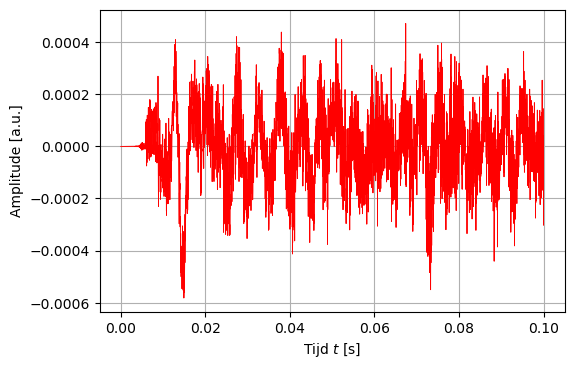

In [4]:
t = np.linspace(0, duration, int(fs*duration)) # maak (voor het gemak) een tijd as
plt.figure(dpi=100)
plt.plot(t, arr, 'r-', ms=0.5, lw=0.5)
plt.grid()
plt.xlabel(r"Tijd $t$ [s]")
plt.ylabel(r"Amplitude [a.u.]") # arbitrary units (we hebben niets gekalibreerd)

# Geluid afspelen
Demonstratie voor het afspelen van een geluid.

In [5]:
myrecording = sd.play(arr, fs, device=1) # speel de array af 
#kies hier de output van een speaker/box

# Het maken van een geluid
We weten dat de geluidsarray een vorm heeft van (Nsamples, Nchannels) waarbij N een integer is. We gaan deze kennis gebruiken om een frequentie naar keuze te maken en af te spelen. 

We maken een array

$\mathrm{arr} = \sin(2\pi \cdot f \cdot t )$

waarbij $f$ de frequentie van de sinus is en $t$ is een array met de tijd. De tijd maken we door een array te initialiseren van $t=0$ tot $t=t_\mathrm{tot}$ in $fs \cdot t_\mathrm{tot}$ stappen.

In [6]:
f = 1e6 # frequentie van de sinus
t_tot = 1 # totale tijdsduur van het geluid
t = np.linspace(0, t_tot, int(fs*t_tot)) # 0 tot t_tot seconden in fs*t_tot

arr = np.sin(2*np.pi*f*t) # np.exp(t) voor een sweep
sd.play(arr, fs, device=1) # speel de array af

## Plot van de eerste 100 samples
Demonstratie van het weergeven van de eerste 100 datapunten.

Text(0, 0.5, 'Amplitude [a.u.]')

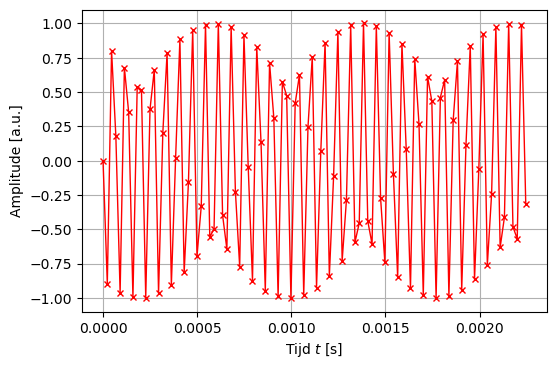

In [7]:
plt.figure(dpi=100)
plt.plot(t[:100],arr[:100], 'rx-', ms=4.0, lw=1)
plt.grid()
plt.xlabel(r"Tijd $t$ [s]")
plt.ylabel(r"Amplitude [a.u.]")

# Fast Fourier Transformatie (FFT) van de geluidsarray
Voor details zie [link](https://www.delftstack.com/howto/python/fft-example-in-python/#use-the-python-numpy-fft-module-for-fast-fourier-transform). Uitleg over FFT komt later in de opleiding. Voor nu gaat het er slechts om dat je een frequentie spectrum kan maken van een geluidsarray. Onderstaande code demonstreert hoe het maken van een frequentie spectrum tot stand komt. Dit hoef je niet te kunnen en/of te begrijpen. De code wordt gebruikt binnen `mijngeluid.py`.

Text(0, 0.5, 'Amplitude [a.u.]')

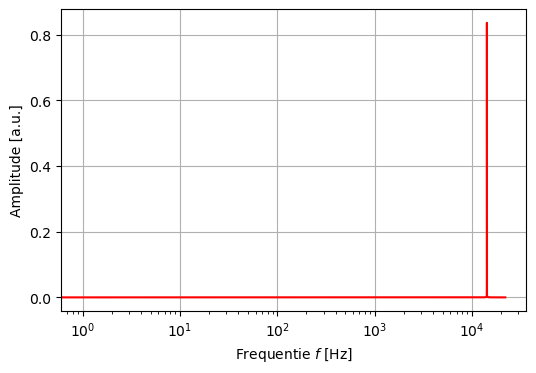

In [8]:
N = int(fs*t_tot) # Nsamples in signaal
T = t_tot/N # Sampling tijd

fhat = np.fft.fft(arr)
x = np.linspace(0.0, 1.0/(2.0*T), N//2) # frequentie
y = 2.0/N * np.abs(fhat[:N//2]) # Intensteit ||.||^2

plt.figure(dpi=100)
plt.plot(x,y, 'r-')
plt.grid()
#plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"Frequentie $f$ [Hz]")
plt.ylabel(r"Amplitude [a.u.]")

De zojuist gemaakt `fft()` functie zet het gehele tijdsignaal om in een frequentie spectrum. Wij willen bovenstaand figuur als functie van de tijd, zodat je kan volgen hoe de amplitudes van frequenties veranderen. Dit doen we door het signaal `arr` op te splitsen in $N$ bins en per bin een FFT te doen. Dit is uitgewerkt in de `fft_partitioned()` functie binnen `mijngeluid.py`. De code uit `mijngeluid.py` hoef je niet te kennen.

IS IEDERE BIN NORMED?

In [9]:
df = fft_partitioned(arr, fs, t_tot, t_bin=1e-2) # t_bin is de bin grootte in seconden
df

,t,f,I
0,0.01,0.000000,0.003441
1,0.01,100.684932,0.003442
2,0.01,201.369863,0.003442
3,0.01,302.054795,0.003443
4,0.01,402.739726,0.003444
...,...,...,...
215,1.00,21647.260274,0.000963
216,1.00,21747.945205,0.000939
217,1.00,21848.630137,0.000920
218,1.00,21949.315068,0.000906


Kun je controleren of bovenstaande code klopt? Laten we het tijdsafhankelijke frequentiespectrum plotten.

<ipython-input-10-89dec95d18f2>:6: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(label="Amplitude [a.u.]", norm=True)


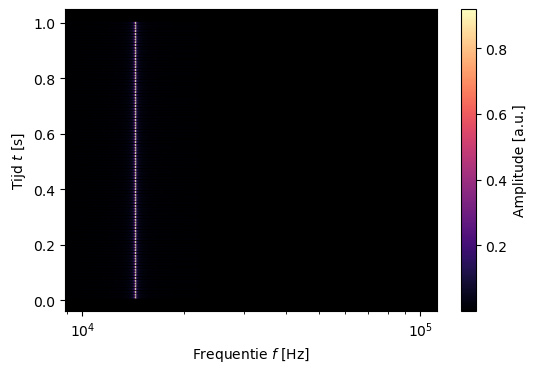

In [10]:
plt.figure(dpi=100)
ax = plt.axes()
ax.set_facecolor("black") # voor het gebruikersgemak (verwijder comments en kijk wat het doet als functie van t_bin)

plt.scatter(df.f, df.t, c=df.I, cmap='magma', marker='.' ,s=1)
plt.colorbar(label="Amplitude [a.u.]", norm=True)
plt.xlabel("Frequentie $f$ [Hz]")
plt.ylabel("Tijd $t$ [s]")
plt.xscale('log')
#plt.xlim([0, 2000])

# Tegelijkertijd afspelen en opnemen van geluid

In [129]:
geluid = np.concatenate([arr, np.zeros(int(fs*1))])

In [130]:
opname = sd.playrec(geluid, fs, channels=1)

Text(0, 0.5, 'Amplitude [a.u.]')

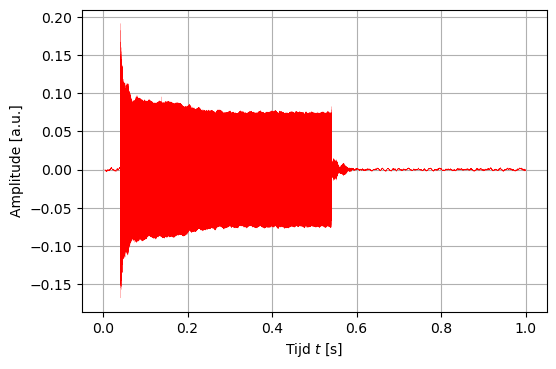

In [131]:
t = np.linspace(0,1, geluid.shape[0])

plt.figure(dpi=100)
plt.plot(t,opname, 'r-', lw=0.1)
plt.grid()
plt.xlabel(r"Tijd $t$ [s]")
plt.ylabel(r"Amplitude [a.u.]")

# Spectrum van de opname

<ipython-input-132-217832bdc860>:8: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(label="Amplitude [a.u.]", norm=True)


Text(0, 0.5, 'Tijd $t$ [s]')

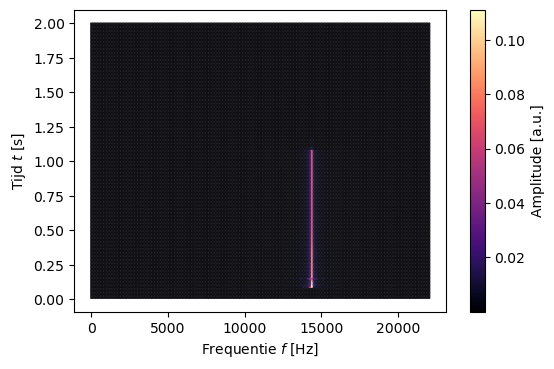

In [132]:
df = fft_partitioned(opname[:,0], fs, t_tot=opname.shape[0]/fs, t_bin=1e-2)

plt.figure(dpi=100)
#ax = plt.axes()
#ax.set_facecolor("black") # voor het gebruikersgemak

plt.scatter(df.f, df.t, c=df.I, cmap='magma', marker='.' ,s=1)
plt.colorbar(label="Amplitude [a.u.]", norm=True)
plt.xlabel("Frequentie $f$ [Hz]")
plt.ylabel("Tijd $t$ [s]")
#plt.xscale('log')
#plt.xlim([1e3, 3e4])

## Demonstratie extraheren van de nagalmtijd (op het oog)
Hint: Filter `df` op een frequentie bereik.

In [133]:
import pandas as pd

In [134]:
df2 = df[df['f'].between(14375,14425)]
df2
# dataframe gefilterd op het juiste frequentie bereik

,t,f,I
143,0.01,14397.945205,1.366469e-09
143,0.02,14397.945205,1.545648e-05
143,0.03,14397.945205,1.251828e-05
143,0.04,14397.945205,1.030265e-05
143,0.05,14397.945205,1.671532e-05
...,...,...,...
143,1.96,14397.945205,1.270048e-05
143,1.97,14397.945205,8.840502e-06
143,1.98,14397.945205,5.526335e-06
143,1.99,14397.945205,1.200664e-05


In [135]:
t = df2.t
I = 10*np.log10((df2.I/(10*10**-12)))
#intensiteit naar db

(1.0, 2.1)

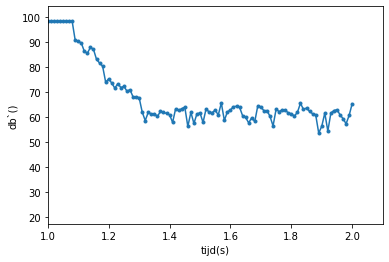

In [136]:
plt.plot(t,I, '.-')
plt.xlabel('tijd(s)')
plt.ylabel('db`()')
plt.xlim([1,2.1]) # stel jouw xlim af op je eigen meting zodat je goed de meting kan aflezen
#plot nagalmtijd

In [45]:
# df maken met nagalm tijd op verschillende posities x,y, nagalmtijd
# hiervan plot maken 

x = [1.0,2.0]
y = [1.0,2.0]
t = [0.1,0.2]
df = pd.DataFrame(0, index=range(x), columns=range(y))

In [153]:
x = [0.1, 1, 1.9, 2.7, 3.6, 0.1, 1, 1.9, 2.7, 3.6, 0.1, 1, 1.9, 2.7, 3.6, 0.1, 1, 1.9, 2.7, 3.6, 0.1, 1, 1.9, 2.7, 3.6, 0.1, 1, 1.9, 2.7, 3.6]
y = [0.1, 0.1, 0.1, 0.1, 0.1, 1.65, 1.65, 1.65, 1.65, 1.65, 3.3, 3.3, 3.3, 3.3, 3.3, 4.95, 4.95, 4.95, 4.95, 4.95, 6.6, 6.6, 6.6, 6.6, 6.6, 8.25, 8.25, 8.25, 8.25, 8.25]
t = [17, 20, 17, 17, 17, 22, 23, 27, 22, 27, 17, 22, 28, 32, 32, 29, 24, 22, 32, 31, 28, 30, 27, 28, 27, 17, 16, 22, 23, 22]

df3 = pd.DataFrame(np.array([x,y,t]).T, columns=['x','y','t'])
df3

,x,y,t
0,0.1,0.10,17.0
1,1.0,0.10,20.0
2,1.9,0.10,17.0
3,2.7,0.10,17.0
4,3.6,0.10,17.0
5,0.1,1.65,22.0
6,1.0,1.65,23.0
7,1.9,1.65,27.0
8,2.7,1.65,22.0
9,3.6,1.65,27.0


<ipython-input-155-37c2ff7109b0>:2: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(label="nagalmtijd (ms)", norm=True)


Text(0, 0.5, 'y[m]')

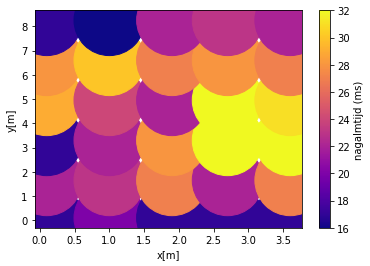

In [155]:
plt.scatter(df3.x, df3.y,c=df3.t, cmap='plasma', marker='.', s=20000)
plt.colorbar(label="nagalmtijd (ms)", norm=True)
plt.xlabel("x[m]")
plt.ylabel("y[m]")